In [2]:
import torch
import os
from torch.utils.data import TensorDataset, DataLoader

#import time
#import numpy as np
#from torchvision import datasets
#import torchvision.transforms as transforms
#from torch.utils.data.sampler import SubsetRandomSampler
#import torch.nn as nn
#import torch.nn.functional as F
#import torch.optim as optim
#import torchvision.models as models
#import matplotlib.pyplot as plt
#import cv2

#import torch
#import numpy as np
#import pickle
#import scipy.io
#from torch.utils.data import Dataset, DataLoader
#from torchvision import transforms, utils
#%matplotlib inline


In [3]:
torch.cuda.set_device(0)

In [4]:
train_on_gpu = torch.cuda.is_available()

In [5]:
cd pytorch_objectdetecttrack-master

[Errno 2] No such file or directory: 'pytorch_objectdetecttrack-master'
/home/eng_mostafa_shahin_19/Action-detection--intellihack-


In [6]:
from models import *
from utils import *
import os, sys, time, datetime, random
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable
import cv2
from PIL import Image

In [7]:
from sort import *

In [8]:
f_rnn = torch.load('final_f_rnn.pt')
b_rnn = torch.load('final_b_rnn.pt')
cnn_model = torch.load('/home/eng_mohammed_saad_18/ensembledModel.jfc_6,200_95e.pt',map_location = 'cpu')
if train_on_gpu:
    f_rnn.cuda()
    b_rnn.cuda()
    cnn_model.cuda()

In [9]:
train_dir      = '/home/eng_mohammed_saad_18/dataset/train'
trainlabel_dir = '/home/eng_mohammed_saad_18/dataset/trainlabel'

valid_dir      = '/home/eng_mohammed_saad_18/dataset/valid'
validlabel_dir = '/home/eng_mohammed_saad_18/dataset/validlabel'

test_dir       = '/home/eng_mohammed_saad_18/dataset/test'          
testlabel_dir  = '/home/eng_mohammed_saad_18/dataset/testlabel'

In [10]:
def ret(x):
    return int(x[0:-11])
def ret2(x):
    return int(x[-10])

video_file_list = os.listdir(test_dir)
video_file_list = sorted(video_file_list,key= ret2)
video_file_list = sorted(video_file_list,key= ret)

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

In [12]:
config_path='config/yolov3.cfg'
weights_path='config/yolov3.weights'
class_path='config/coco.names'
img_size=416
conf_thres=0.5
nms_thres=0.4

# load model and put into eval mode
model = Darknet(config_path, img_size=img_size)
model.load_weights(weights_path)
model.to(device)
model.eval()
data_transforms = transforms.Compose([ transforms.ToTensor()])
if device == torch.device("cpu"):
    Tensor = torch.FloatTensor
else:
    Tensor = torch.cuda.FloatTensor

/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [13]:
def detect_image(img):
    # scale and pad image
    ratio = min(img_size/img.size[0], img_size/img.size[1])
    imw = round(img.size[0] * ratio)
    imh = round(img.size[1] * ratio)
    img_transforms = transforms.Compose([ transforms.Resize((imh, imw)),

         transforms.Pad((max(int((imh-imw)/2),0), max(int((imw-imh)/2),0), max(int((imh-imw)/2),0), max(int((imw-imh)/2),0)),
                        (128,128,128)),
         transforms.ToTensor(),
         ])
    # convert image to Tensor
    image_tensor = img_transforms(img).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input_img = Variable(image_tensor.type(Tensor))
    # run inference on the model and get detections
    with torch.no_grad():
        detections = model(input_img)
        detections = utils.non_max_suppression(detections, 80, conf_thres, nms_thres)
    return detections[0]

In [14]:
def chunk(features,seq_length):
    for i in range(0, len(features)-seq_length, 1):
        yield features[i:i+seq_length]
             

def batching_data(cnn_out, sequence_length):
    rNpArr = np.flip(cnn_out.cpu().numpy(),0).copy()   
    reversed_cnn_out = torch.from_numpy(rNpArr)
    
    cnn_out = torch.cat((cnn_out[:sequence_length],cnn_out),0)
    reversed_cnn_out = torch.cat((reversed_cnn_out[:sequence_length],reversed_cnn_out),0)
    
    feature_tensors = torch.stack(list(chunk(cnn_out, sequence_length)))
    reversed_feature_tensors = torch.stack(list(chunk(reversed_cnn_out, sequence_length)))
    
    return feature_tensors, reversed_feature_tensors
    
    '''
    data = TensorDataset(feature_tensors)
    data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=shuffling,drop_last=False) 
    reversed_data = TensorDataset(reversed_feature_tensors)
    reversed_data_loader = torch.utils.data.DataLoader(reversed_data, batch_size=batch_size,
                                                       shuffle=shuffling,drop_last=False)
    return data_loader, reversed_data_loader
    '''

In [65]:
def get_video_frames(video_path):
    
    frames_tensor = torch.FloatTensor(1,3,256,256).to(device)
    cropped_frames_tensor = torch.FloatTensor(1,3,256,256).to(device)

    cap = cv2.VideoCapture(video_path)
    count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    mot_tracker = Sort()
    frames = 0
    box_h = 556
    box_w = 556
    y1 = 300
    x1 = 300
    idx=0
    n = 0

    while(True):
        ret, frame = cap.read()
        if not ret:
            break
        idx+=1
        frame = cv2.cvtColor( frame, cv2.COLOR_BGR2RGB)
        pilimg = Image.fromarray(frame)
        detections = detect_image(pilimg)
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        img = np.array(pilimg)
        pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
        pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
        unpad_h = img_size - pad_y
        unpad_w = img_size - pad_x

        if detections is not None:
            tracked_objects = mot_tracker.update(detections.cpu())
            unique_labels = detections[:, -1].cpu().unique()
            n_cls_preds = len(unique_labels)

            for x1, y1, x2, y2, obj_id, cls_pred in tracked_objects:
                box_h = int(((y2 - y1) / unpad_h) * img.shape[0])
                box_w = int(((x2 - x1) / unpad_w) * img.shape[1])
                y1 = int(((y1 - pad_y // 2) / unpad_h) * img.shape[0])
                x1 = int(((x1 - pad_x // 2) / unpad_w) * img.shape[1])
            starty = y1-20 if y1>20 else 0    
            startx = x1-20 if x1>20 else 0 
            roi = frame[starty:y1 + box_h+50, startx:x1 + box_w+50,:]
        else:
            starty = y1-20 if y1>20 else 0    
            startx = x1-20 if x1>20 else 0
            roi = frame[starty:y1 + box_h+50, startx:x1 + box_w+50,:]
        if idx%2==0:
            n+=1
            #frame = cv2.resize(frame, (256, 256))
            #roi   = cv2.resize(roi, (256, 256))
            #cv2.imwrite('frames/'+str(n)+'.png',frame)
            #cv2.imwrite('cropped_frames/'+str(n)+'.png',roi)
            frame = data_transforms(cv2.resize(frame, (256, 256))).to(device)
            roi = data_transforms(cv2.resize(roi, (256, 256))).to(device)
            frames_tensor = torch.cat((frames_tensor,frame.unsqueeze(0)),0)
            cropped_frames_tensor = torch.cat((cropped_frames_tensor,roi.unsqueeze(0)),0)
            print(n)
    frames_tensor = frames_tensor[1:]
    cropped_frames_tensor = cropped_frames_tensor[1:]
    return frames_tensor, cropped_frames_tensor, count

In [16]:
def CNN_pass(frames_tensor,cropped_frames_tensor):   
    
    cnn_out200 = torch.FloatTensor(1,200).to(device)
    cnn_out6 = torch.FloatTensor(1,6).to(device)
    cnn_model.eval()
    with torch.no_grad():
        for frame, cropped_frame in zip(frames_tensor,cropped_frames_tensor):
            if train_on_gpu:
                frame  , cropped_frame  = frame.unsqueeze(0).cuda(), cropped_frame.unsqueeze(0).cuda()
            out6,out200 = cnn_model.forward(frame,cropped_frame)
            cnn_out6 = torch.cat((cnn_out6,out6),0)
            cnn_out200 = torch.cat((cnn_out200,out200),0)

    cnn_out6    = cnn_out6[1:]
    cnn_out200  = cnn_out200[1:]
    return cnn_out6, cnn_out200

In [17]:
def RNN_pass(data_sequences, reversed_sequences):
    
    hiddenf = f_rnn.init_hidden(data_sequences.size(0))
    hiddenb = b_rnn.init_hidden(data_sequences.size(0))
    
    f_rnn.eval()
    b_rnn.eval()  
    
    with torch.no_grad():
        outputf, hiddenf = f_rnn(data_sequences.to(device)    , hiddenf)
        outputb, hiddenb = b_rnn(reversed_sequences.to(device), hiddenb)
        
    outputf = F.log_softmax(outputf, dim=1)
    outputb = F.log_softmax(outputb, dim=1)
    
    return outputf, outputb

In [18]:
video_file_list[0]

'27_1_crop.mp4'

In [19]:
video_path = test_dir+'/'+video_file_list[0]
frames_tensor,cropped_frames_tensor, count =  get_video_frames(video_path)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031


In [20]:
print(frames_tensor[:5])
print(cropped_frames_tensor[:5])

tensor([[[[0.9333, 0.9333, 0.9333,  ..., 0.9765, 0.9725, 0.9725],
          [0.9333, 0.9333, 0.9333,  ..., 0.9647, 0.9569, 0.9569],
          [0.9333, 0.9333, 0.9333,  ..., 0.9804, 0.9725, 0.9725],
          ...,
          [0.5333, 0.5098, 0.4471,  ..., 0.0275, 0.0353, 0.0353],
          [0.5098, 0.4784, 0.4078,  ..., 0.0275, 0.0353, 0.0353],
          [0.4588, 0.4196, 0.3922,  ..., 0.0275, 0.0353, 0.0353]],

         [[0.9765, 0.9765, 0.9765,  ..., 0.9647, 0.9765, 0.9765],
          [0.9765, 0.9765, 0.9765,  ..., 0.9216, 0.9294, 0.9294],
          [0.9765, 0.9765, 0.9765,  ..., 0.9059, 0.9059, 0.9059],
          ...,
          [0.5804, 0.5569, 0.5137,  ..., 0.0353, 0.0353, 0.0353],
          [0.5569, 0.5255, 0.4745,  ..., 0.0353, 0.0353, 0.0353],
          [0.5059, 0.4667, 0.4588,  ..., 0.0353, 0.0353, 0.0353]],

         [[0.9804, 0.9804, 0.9804,  ..., 0.9059, 0.9137, 0.9137],
          [0.9804, 0.9804, 0.9804,  ..., 0.8667, 0.8745, 0.8745],
          [0.9804, 0.9804, 0.9804,  ..., 0

In [21]:
cnn_out6,  cnn_out200 = CNN_pass(frames_tensor,cropped_frames_tensor)

In [22]:
for l in cnn_out200[:5]:
    print(l[:5])

tensor([ 6.7944e-01,  5.5420e-01, -8.9296e-02,  4.5401e-01, -7.3728e-06],
       device='cuda:0')
tensor([ 1.1184e+00,  9.6321e-01, -5.8834e-03,  5.7499e-01, -8.0431e-06],
       device='cuda:0')
tensor([ 1.0897e+00,  9.1920e-01,  4.0480e-02,  5.8899e-01, -7.7048e-06],
       device='cuda:0')
tensor([ 1.0277e+00,  8.8797e-01,  3.5006e-02,  5.5788e-01, -7.7078e-06],
       device='cuda:0')
tensor([ 1.0712e+00,  9.0723e-01,  5.0842e-02,  5.9301e-01, -8.0955e-06],
       device='cuda:0')


In [23]:
sequence_length = 75
data_sequences, reversed_sequences = batching_data(cnn_out200,sequence_length)

In [24]:
print(data_sequences[sequence_length:sequence_length+5])
print(reversed_sequences[sequence_length:sequence_length+5])

tensor([[[ 0.6794,  0.5542, -0.0893,  ...,  0.5145, -0.2219,  0.3157],
         [ 1.1184,  0.9632, -0.0059,  ...,  0.8663, -0.1706,  0.6063],
         [ 1.0897,  0.9192,  0.0405,  ...,  0.8228, -0.1620,  0.5854],
         ...,
         [ 0.8894,  0.8707, -0.1337,  ...,  0.8168, -0.3031,  0.5591],
         [ 0.7899,  0.7885, -0.1159,  ...,  0.7333, -0.2978,  0.5069],
         [ 0.8719,  0.8189, -0.0592,  ...,  0.7585, -0.2830,  0.5284]],

        [[ 1.1184,  0.9632, -0.0059,  ...,  0.8663, -0.1706,  0.6063],
         [ 1.0897,  0.9192,  0.0405,  ...,  0.8228, -0.1620,  0.5854],
         [ 1.0277,  0.8880,  0.0350,  ...,  0.7895, -0.1553,  0.5725],
         ...,
         [ 0.7899,  0.7885, -0.1159,  ...,  0.7333, -0.2978,  0.5069],
         [ 0.8719,  0.8189, -0.0592,  ...,  0.7585, -0.2830,  0.5284],
         [ 0.8596,  0.8387,  0.1140,  ...,  0.7210, -0.2259,  0.5937]],

        [[ 1.0897,  0.9192,  0.0405,  ...,  0.8228, -0.1620,  0.5854],
         [ 1.0277,  0.8880,  0.0350,  ...,  0

In [25]:
outputf, outputb = RNN_pass(data_sequences, reversed_sequences)

In [26]:
rNpArr = np.flip(outputb.cpu().numpy(),0).copy()   
outputb = torch.from_numpy(rNpArr).to(device)

In [29]:
len(outputf[sequence_length:])

1956

In [31]:
print(outputf[sequence_length+100:sequence_length+105])
print(outputb[sequence_length+100:sequence_length+105])

tensor([[-5.1113e+00, -4.6991e+00, -7.1054e+00, -8.8600e+00, -1.6935e-02,
         -7.2678e+00],
        [-4.9541e+00, -4.4129e+00, -6.9202e+00, -8.6134e+00, -2.1445e-02,
         -7.0439e+00],
        [-5.4010e+00, -5.3112e+00, -7.3813e+00, -9.3545e+00, -1.0709e-02,
         -7.6114e+00],
        [-5.6546e+00, -5.7140e+00, -7.7653e+00, -9.7983e+00, -7.6685e-03,
         -7.9326e+00],
        [-4.4794e+00, -3.3807e+00, -6.5931e+00, -7.9691e+00, -4.9946e-02,
         -6.4133e+00]], device='cuda:0')
tensor([[-5.2853e+00, -8.4467e+00, -6.1792e+00, -8.6832e+00, -7.9107e-03,
         -7.9346e+00],
        [-5.4258e+00, -8.4175e+00, -6.2843e+00, -8.8678e+00, -6.9509e-03,
         -8.1188e+00],
        [-4.1386e+00, -7.1555e+00, -4.7093e+00, -7.9020e+00, -2.7555e-02,
         -6.8379e+00],
        [-5.0630e+00, -7.8983e+00, -5.8358e+00, -8.6875e+00, -1.0222e-02,
         -7.8690e+00],
        [-4.8537e+00, -7.4671e+00, -5.5998e+00, -8.6961e+00, -1.2752e-02,
         -7.7422e+00]], device='cud

In [92]:
outputf[:5]

tensor([[-5.4359e-03, -9.1569e+00, -1.2334e+01, -1.4668e+01, -9.5998e+00,
         -5.2508e+00],
        [-8.0862e-03, -7.8713e+00, -1.1679e+01, -1.3856e+01, -9.0420e+00,
         -4.8869e+00],
        [-1.9274e-03, -9.5729e+00, -1.2968e+01, -1.4976e+01, -1.0295e+01,
         -6.3092e+00],
        [-9.3937e-04, -1.0511e+01, -1.3626e+01, -1.5437e+01, -1.1092e+01,
         -7.0191e+00],
        [-8.3447e-04, -1.0753e+01, -1.3734e+01, -1.5501e+01, -1.1251e+01,
         -7.1331e+00]], device='cuda:0')

In [37]:
final_out = (outputf + outputb) / 2

In [38]:
final_out[:5]

tensor([[-2.7652e-03, -1.0815e+01, -1.1026e+01, -1.4571e+01, -1.1610e+01,
         -7.8471e+00],
        [-4.0927e-03, -1.0164e+01, -1.0670e+01, -1.4146e+01, -1.1294e+01,
         -7.6544e+00],
        [-1.0176e-03, -1.0963e+01, -1.1272e+01, -1.4655e+01, -1.1867e+01,
         -8.3337e+00],
        [-5.2452e-04, -1.1412e+01, -1.1594e+01, -1.4880e+01, -1.2261e+01,
         -8.6767e+00],
        [-4.8018e-04, -1.1429e+01, -1.1580e+01, -1.4855e+01, -1.2289e+01,
         -8.6650e+00]], device='cuda:0')

In [39]:
_, pred = torch.max(final_out, 1)

In [40]:
pred[200:250]

tensor([4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2,
        2, 2], device='cuda:0')

In [41]:
final_pred = torch.zeros(count) 

In [42]:
for i,p in enumerate(pred):
    final_pred[i*2:i*2+2] = p

In [43]:
final_pred[400:500]

tensor([4., 4., 4., 4., 2., 2., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
        4., 4., 4., 4., 4., 4., 4., 4., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2.])

In [44]:
len(final_pred)

4063

In [45]:
import h5py
gt_file = h5py.File('MERL_gt.hdf5','r')
gt = gt_file.get('data')[:]

In [48]:
for i,(g,p) in enumerate(zip(gt[:4063],final_pred)):
    print('frame',i,':',g,'',int(p.item()))

frame 0 : 0  0
frame 1 : 0  0
frame 2 : 0  0
frame 3 : 0  0
frame 4 : 0  0
frame 5 : 0  0
frame 6 : 0  0
frame 7 : 0  0
frame 8 : 0  0
frame 9 : 0  0
frame 10 : 0  0
frame 11 : 0  0
frame 12 : 0  0
frame 13 : 0  0
frame 14 : 0  0
frame 15 : 0  0
frame 16 : 0  0
frame 17 : 0  0
frame 18 : 0  0
frame 19 : 0  0
frame 20 : 0  0
frame 21 : 0  0
frame 22 : 0  0
frame 23 : 0  0
frame 24 : 0  0
frame 25 : 0  0
frame 26 : 0  0
frame 27 : 0  0
frame 28 : 0  0
frame 29 : 0  0
frame 30 : 0  0
frame 31 : 0  0
frame 32 : 0  0
frame 33 : 0  0
frame 34 : 0  0
frame 35 : 0  0
frame 36 : 0  0
frame 37 : 0  0
frame 38 : 0  0
frame 39 : 0  0
frame 40 : 0  0
frame 41 : 0  0
frame 42 : 0  0
frame 43 : 0  0
frame 44 : 0  0
frame 45 : 0  0
frame 46 : 0  0
frame 47 : 0  0
frame 48 : 0  0
frame 49 : 0  0
frame 50 : 0  0
frame 51 : 0  0
frame 52 : 0  0
frame 53 : 0  0
frame 54 : 0  0
frame 55 : 0  0
frame 56 : 0  0
frame 57 : 0  0
frame 58 : 0  0
frame 59 : 0  0
frame 60 : 0  0
frame 61 : 0  0
frame 62 : 0  0
fr

frame 712 : 2  4
frame 713 : 2  4
frame 714 : 2  4
frame 715 : 2  4
frame 716 : 0  4
frame 717 : 0  4
frame 718 : 0  4
frame 719 : 4  4
frame 720 : 4  4
frame 721 : 4  4
frame 722 : 4  4
frame 723 : 4  4
frame 724 : 4  4
frame 725 : 4  4
frame 726 : 4  4
frame 727 : 4  4
frame 728 : 4  4
frame 729 : 4  4
frame 730 : 4  4
frame 731 : 4  4
frame 732 : 4  4
frame 733 : 4  4
frame 734 : 4  4
frame 735 : 4  4
frame 736 : 4  4
frame 737 : 4  4
frame 738 : 4  4
frame 739 : 4  4
frame 740 : 4  4
frame 741 : 4  4
frame 742 : 4  4
frame 743 : 4  4
frame 744 : 4  4
frame 745 : 4  4
frame 746 : 4  4
frame 747 : 4  4
frame 748 : 4  4
frame 749 : 4  4
frame 750 : 4  4
frame 751 : 4  4
frame 752 : 4  4
frame 753 : 4  4
frame 754 : 4  4
frame 755 : 4  4
frame 756 : 4  4
frame 757 : 4  4
frame 758 : 4  4
frame 759 : 4  4
frame 760 : 4  4
frame 761 : 4  4
frame 762 : 4  4
frame 763 : 4  4
frame 764 : 4  4
frame 765 : 4  4
frame 766 : 4  4
frame 767 : 4  4
frame 768 : 4  4
frame 769 : 4  4
frame 770 : 4 

frame 1451 : 4  4
frame 1452 : 4  4
frame 1453 : 4  4
frame 1454 : 4  4
frame 1455 : 4  4
frame 1456 : 4  4
frame 1457 : 4  4
frame 1458 : 4  4
frame 1459 : 4  4
frame 1460 : 4  4
frame 1461 : 4  4
frame 1462 : 4  4
frame 1463 : 4  4
frame 1464 : 4  4
frame 1465 : 4  4
frame 1466 : 4  4
frame 1467 : 4  4
frame 1468 : 4  4
frame 1469 : 4  4
frame 1470 : 4  4
frame 1471 : 4  4
frame 1472 : 4  4
frame 1473 : 4  4
frame 1474 : 4  4
frame 1475 : 4  4
frame 1476 : 4  4
frame 1477 : 4  4
frame 1478 : 4  4
frame 1479 : 4  4
frame 1480 : 4  4
frame 1481 : 4  4
frame 1482 : 4  4
frame 1483 : 4  4
frame 1484 : 4  4
frame 1485 : 4  4
frame 1486 : 4  4
frame 1487 : 4  4
frame 1488 : 4  4
frame 1489 : 4  4
frame 1490 : 4  4
frame 1491 : 4  4
frame 1492 : 4  4
frame 1493 : 4  4
frame 1494 : 4  4
frame 1495 : 4  4
frame 1496 : 4  4
frame 1497 : 4  4
frame 1498 : 4  4
frame 1499 : 4  4
frame 1500 : 4  4
frame 1501 : 4  4
frame 1502 : 4  4
frame 1503 : 4  4
frame 1504 : 4  4
frame 1505 : 4  4
frame 1506

frame 2205 : 1  1
frame 2206 : 1  1
frame 2207 : 1  1
frame 2208 : 1  1
frame 2209 : 1  1
frame 2210 : 1  1
frame 2211 : 1  1
frame 2212 : 1  1
frame 2213 : 1  1
frame 2214 : 1  1
frame 2215 : 1  1
frame 2216 : 1  1
frame 2217 : 1  1
frame 2218 : 1  1
frame 2219 : 1  1
frame 2220 : 1  1
frame 2221 : 1  1
frame 2222 : 1  1
frame 2223 : 1  1
frame 2224 : 1  1
frame 2225 : 1  1
frame 2226 : 1  1
frame 2227 : 0  1
frame 2228 : 0  1
frame 2229 : 0  1
frame 2230 : 2  2
frame 2231 : 2  2
frame 2232 : 2  2
frame 2233 : 2  2
frame 2234 : 2  2
frame 2235 : 2  2
frame 2236 : 2  2
frame 2237 : 2  2
frame 2238 : 2  2
frame 2239 : 2  2
frame 2240 : 2  2
frame 2241 : 2  2
frame 2242 : 2  2
frame 2243 : 2  2
frame 2244 : 2  2
frame 2245 : 2  2
frame 2246 : 2  2
frame 2247 : 2  2
frame 2248 : 2  2
frame 2249 : 2  2
frame 2250 : 2  2
frame 2251 : 2  2
frame 2252 : 2  2
frame 2253 : 2  2
frame 2254 : 2  2
frame 2255 : 2  2
frame 2256 : 2  2
frame 2257 : 2  2
frame 2258 : 2  2
frame 2259 : 0  2
frame 2260

frame 2962 : 4  4
frame 2963 : 4  4
frame 2964 : 4  4
frame 2965 : 4  4
frame 2966 : 4  4
frame 2967 : 4  4
frame 2968 : 4  4
frame 2969 : 4  4
frame 2970 : 4  4
frame 2971 : 4  4
frame 2972 : 4  4
frame 2973 : 4  4
frame 2974 : 4  4
frame 2975 : 4  4
frame 2976 : 4  4
frame 2977 : 4  4
frame 2978 : 4  4
frame 2979 : 4  4
frame 2980 : 4  4
frame 2981 : 4  4
frame 2982 : 4  4
frame 2983 : 4  4
frame 2984 : 4  4
frame 2985 : 4  4
frame 2986 : 4  4
frame 2987 : 4  4
frame 2988 : 4  4
frame 2989 : 4  4
frame 2990 : 4  4
frame 2991 : 4  4
frame 2992 : 4  4
frame 2993 : 4  4
frame 2994 : 4  4
frame 2995 : 4  4
frame 2996 : 4  4
frame 2997 : 4  4
frame 2998 : 4  4
frame 2999 : 4  4
frame 3000 : 4  4
frame 3001 : 4  4
frame 3002 : 4  4
frame 3003 : 4  4
frame 3004 : 4  4
frame 3005 : 4  4
frame 3006 : 4  4
frame 3007 : 4  4
frame 3008 : 4  4
frame 3009 : 4  4
frame 3010 : 4  4
frame 3011 : 4  4
frame 3012 : 4  4
frame 3013 : 4  4
frame 3014 : 4  4
frame 3015 : 4  4
frame 3016 : 4  4
frame 3017

frame 3794 : 0  0
frame 3795 : 0  0
frame 3796 : 0  0
frame 3797 : 0  0
frame 3798 : 0  0
frame 3799 : 0  0
frame 3800 : 0  0
frame 3801 : 0  0
frame 3802 : 0  0
frame 3803 : 0  0
frame 3804 : 0  0
frame 3805 : 0  0
frame 3806 : 0  0
frame 3807 : 0  0
frame 3808 : 0  0
frame 3809 : 0  0
frame 3810 : 0  0
frame 3811 : 0  0
frame 3812 : 0  0
frame 3813 : 0  0
frame 3814 : 0  0
frame 3815 : 0  0
frame 3816 : 0  0
frame 3817 : 0  0
frame 3818 : 0  0
frame 3819 : 0  0
frame 3820 : 0  0
frame 3821 : 0  0
frame 3822 : 0  0
frame 3823 : 0  0
frame 3824 : 0  0
frame 3825 : 0  0
frame 3826 : 0  0
frame 3827 : 0  0
frame 3828 : 0  0
frame 3829 : 0  0
frame 3830 : 0  0
frame 3831 : 0  0
frame 3832 : 0  0
frame 3833 : 0  0
frame 3834 : 0  0
frame 3835 : 0  0
frame 3836 : 0  0
frame 3837 : 0  0
frame 3838 : 0  0
frame 3839 : 0  0
frame 3840 : 0  0
frame 3841 : 0  0
frame 3842 : 0  0
frame 3843 : 0  0
frame 3844 : 0  0
frame 3845 : 0  0
frame 3846 : 0  0
frame 3847 : 0  0
frame 3848 : 0  0
frame 3849

In [51]:
gt_tensor = torch.from_numpy(gt[:4063]).float()
acc=torch.stack(list(final_pred==gt_tensor))
print('accuracy  : ',(torch.sum(acc).item()/len(acc))*100, '%')

accuracy  :  95.79128722618755 %


In [52]:
_, pred2 = torch.max(outputf, 1)

In [53]:
final_pred2 = torch.zeros(count) 

In [54]:
for i,p in enumerate(pred2):
    final_pred2[i*2:i*2+2] = p

In [ ]:
for i,(g,p) in enumerate(zip(gt[:4063],pred2)):
    print('frame',i,':',g,'',p.item())

In [55]:
acc=torch.stack(list(final_pred2==gt_tensor))
print('accuracy  : ',(torch.sum(acc).item()/len(acc))*100, '%')

accuracy  :  94.04380999261629 %


In [58]:
len(final_pred2.numpy())

4063

In [72]:
def inferOnVideo(video_path):
    
    sequence_length = 75
    frames_tensor,cropped_frames_tensor, count =  get_video_frames(video_path)
    print(count)
    cnn_out6,  cnn_out200 = CNN_pass(frames_tensor,cropped_frames_tensor)
    data_sequences, reversed_sequences = batching_data(cnn_out200,sequence_length)
    outputf, outputb = RNN_pass(data_sequences, reversed_sequences)
    rNpArr = np.flip(outputb.cpu().numpy(),0).copy()   
    outputb = torch.from_numpy(rNpArr).to(device)
    final_out = (outputf + outputb) / 2
    _, pred = torch.max(final_out, 1)
    final_pred = torch.zeros(count)
    
    for i,p in enumerate(pred):
        final_pred[i*2:i*2+2] = p
        
    return final_pred.numpy()
    

In [66]:
video_path = test_dir+'/'+video_file_list[1]
cap = cv2.VideoCapture(video_path)
count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
count

4087

In [73]:
result = inferOnVideo(video_path)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
4087


In [74]:
len(result)

4087

In [77]:
result[100:200]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 5., 5., 5., 5., 5., 5., 5., 5.],
      dtype=float32)

In [83]:
gt_tensor = torch.from_numpy(gt[4063:4063+4087]).float()
result = torch.from_numpy(result)
acc=torch.stack(list(result==gt_tensor))
print('accuracy  : ',(torch.sum(acc).item()/len(acc))*100, '%')

accuracy  :  94.20112551994127 %


In [70]:
f_rnn.eval()
b_rnn.eval()
final_out = torch.zeros([len(cnn_out200),6 ], dtype=torch.float64).cuda()
fout=torch.FloatTensor(1,6).cuda()
bout=torch.FloatTensor(1,6).cuda()

with torch.no_grad():
    hiddenf = f_rnn.init_hidden(len(f_data_loader200.dataset))
    hiddenb = b_rnn.init_hidden(len(f_data_loader200.dataset))
    for (fdata,rdata) in zip(f_data_loader200, b_data_loader200):
        
        if train_on_gpu:
            fdata, rdata = fdata[0].cuda(), rdata[0].cuda()
        
        outputf, hiddenf = f_rnn(fdata, hiddenf)
        outputb, hiddenb = b_rnn(rdata, hiddenb)

        outputf = F.log_softmax(outputf, dim=1)
        outputb = F.log_softmax(outputb, dim=1)
        
        fout = torch.cat((fout,outputf),0)
        bout = torch.cat((bout,outputb),0)
    
    
fout = fout[1:]
bout = bout[1:]   
final_out[sequence_length:] = fout
rNpArr = np.flip(bout.cpu().numpy(),0).copy()   
bout = torch.from_numpy(rNpArr)
final_out[:-sequence_length] += bout.double().cuda()
#cnn_tout6 = F.log_softmax(cnn_tout6, dim=1)
#final_out += cnn_tout6.double()
final_out /= 2
_, pred = torch.max(final_out, 1)
#acc=torch.stack(list(pred==all_ttargets.long()))
#print('accuracy  : ',(torch.sum(acc).item()/len(acc))*100, '%')

In [34]:
frames_tensor = torch.FloatTensor(1,3,256,256).to(device)
cropped_frames_tensor = torch.FloatTensor(1,3,256,256).to(device)

video = '/home/eng_mohammed_saad_18/dataset/valid/21_1_crop.mp4'    
cap = cv2.VideoCapture(video)
mot_tracker = Sort()
frames = 0
box_h = 556
box_w = 556
y1 = 300
x1 = 300
idx=0
n = 0

cap.set(cv2.CAP_PROP_POS_FRAMES,6)

while(True):
    idx+=1
    ret, frame = cap.read()
    if not ret:
        break
    frame = cv2.cvtColor( frame, cv2.COLOR_BGR2RGB)
    pilimg = Image.fromarray(frame)
    detections = detect_image(pilimg)
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    img = np.array(pilimg)
    pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
    pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
    unpad_h = img_size - pad_y
    unpad_w = img_size - pad_x

    if detections is not None:
        #print('in if')
        tracked_objects = mot_tracker.update(detections.cpu())
        unique_labels = detections[:, -1].cpu().unique()
        n_cls_preds = len(unique_labels)

        for x1, y1, x2, y2, obj_id, cls_pred in tracked_objects:
            box_h = int(((y2 - y1) / unpad_h) * img.shape[0])
            box_w = int(((x2 - x1) / unpad_w) * img.shape[1])
            y1 = int(((y1 - pad_y // 2) / unpad_h) * img.shape[0])
            x1 = int(((x1 - pad_x // 2) / unpad_w) * img.shape[1])
        starty = y1-20 if y1>20 else 0    
        startx = x1-20 if x1>20 else 0 
        roi = frame[starty:y1 + box_h+50, startx:x1 + box_w+50,:]
    else:
        starty = y1-20 if y1>20 else 0    
        startx = x1-20 if x1>20 else 0
        roi = frame[starty:y1 + box_h+50, startx:x1 + box_w+50,:]
    if idx%12==0:
        n+=1
        frame = data_transforms(cv2.resize(frame, (256, 256))).to(device)
        roi = data_transforms(cv2.resize(roi, (256, 256))).to(device)
        frames_tensor = torch.cat((frames_tensor,frame.unsqueeze(0)),0)
        cropped_frames_tensor = torch.cat((cropped_frames_tensor,roi.unsqueeze(0)),0)
        print(n)
frames_tensor = frames_tensor[1:]
cropped_frames_tensor = cropped_frames_tensor[1:]

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [35]:
sequence_length = 18
batch_size = 256
data = TensorDataset(frames_tensor, cropped_frames_tensor)
data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=False,drop_last=False)

In [36]:
f_rnn = torch.load('/home/eng_mostafa_shahin_19/checkpoints/f_rnn128_20e.pt')
b_rnn = torch.load('/home/eng_mostafa_shahin_19/checkpoints/b_best.pt')
cnn_model = torch.load('/home/eng_mohammed_saad_18/ensembledModel.jfc_6,200_75e.pt',map_location = 'cpu')
if train_on_gpu:
    f_rnn.cuda()
    b_rnn.cuda()
    cnn_model.cuda()

In [37]:
cnn_out200 = torch.FloatTensor(1,200).cuda()
cnn_out6 = torch.FloatTensor(1,6).cuda()
cnn_model.eval()
k=0
with torch.no_grad():
    for data,c_data in data_loader:
        k+=1
        print(k)
        
        if train_on_gpu:
            data  , c_data  = data.cuda(), c_data.cuda()
             
        out6,out200 = cnn_model.forward(data,c_data)
        cnn_out6 = torch.cat((cnn_out6,out6),0)
        cnn_out200 = torch.cat((cnn_out200,out200),0)
cnn_out6    = cnn_out6[1:]
cnn_out200  = cnn_out200[1:]
del data  , c_data


1
2


In [38]:
rnn_batch_size = len(cnn_out200)
f_data_loader200, b_data_loader200 = batching_data(cnn_out200,sequence_length,batch_size = rnn_batch_size,shuffling = False)

In [39]:
rnn_batch_size

349

In [70]:
f_rnn.eval()
b_rnn.eval()
final_out = torch.zeros([len(cnn_out200),6 ], dtype=torch.float64).cuda()
fout=torch.FloatTensor(1,6).cuda()
bout=torch.FloatTensor(1,6).cuda()

with torch.no_grad():
    hiddenf = f_rnn.init_hidden(len(f_data_loader200.dataset))
    hiddenb = b_rnn.init_hidden(len(f_data_loader200.dataset))
    for (fdata,rdata) in zip(f_data_loader200, b_data_loader200):
        
        if train_on_gpu:
            fdata, rdata = fdata[0].cuda(), rdata[0].cuda()
        
        outputf, hiddenf = f_rnn(fdata, hiddenf)
        outputb, hiddenb = b_rnn(rdata, hiddenb)

        outputf = F.log_softmax(outputf, dim=1)
        outputb = F.log_softmax(outputb, dim=1)
        
        fout = torch.cat((fout,outputf),0)
        bout = torch.cat((bout,outputb),0)
    
    
fout = fout[1:]
bout = bout[1:]   
final_out[sequence_length:] = fout
rNpArr = np.flip(bout.cpu().numpy(),0).copy()   
bout = torch.from_numpy(rNpArr)
final_out[:-sequence_length] += bout.double().cuda()
cnn_out6 = F.log_softmax(cnn_out6, dim=1)
#final_out += cnn_out6.double()
#final_out /= 3
_, pred = torch.max(final_out, 1)
#acc=torch.stack(list(pred==all_ttargets.long()))
#print('accuracy  : ',(torch.sum(acc).item()/len(acc))*100, '%')

In [44]:
for i,p in enumerate(pred):
    print(i+1 , p.item())

1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 5
19 0
20 0
21 0
22 0
23 0
24 5
25 5
26 5
27 5
28 5
29 5
30 0
31 5
32 5
33 0
34 5
35 5
36 1
37 1
38 1
39 2
40 2
41 2
42 2
43 4
44 1
45 1
46 2
47 2
48 5
49 5
50 1
51 1
52 2
53 2
54 2
55 2
56 2
57 4
58 4
59 4
60 4
61 4
62 4
63 4
64 4
65 1
66 0
67 5
68 5
69 5
70 5
71 5
72 5
73 5
74 1
75 1
76 1
77 1
78 2
79 2
80 2
81 2
82 5
83 1
84 1
85 1
86 2
87 2
88 2
89 2
90 0
91 4
92 4
93 4
94 4
95 4
96 4
97 4
98 4
99 4
100 4
101 4
102 4
103 4
104 4
105 4
106 4
107 4
108 4
109 4
110 5
111 5
112 5
113 5
114 5
115 5
116 5
117 5
118 5
119 5
120 5
121 5
122 5
123 5
124 5
125 5
126 5
127 5
128 5
129 5
130 5
131 5
132 5
133 5
134 5
135 5
136 5
137 5
138 5
139 5
140 1
141 1
142 1
143 2
144 2
145 4
146 4
147 4
148 4
149 4
150 4
151 4
152 4
153 5
154 0
155 0
156 0
157 0
158 0
159 0
160 0
161 0
162 0
163 0
164 0
165 0
166 0
167 0
168 0
169 0
170 0
171 0
172 0
173 0
174 0
175 0
176 0
177 0
178 0
179 0
180 0
181 0
182 0
183 5
184 5
185 

In [45]:
import csv
with open('/home/eng_mohammed_saad_18/valid_labels.csv', 'r') as f:
    reader = csv.reader(f)
    true_labels = list(reader)
    
print(len(true_labels))

6765


In [50]:
targets = []
for f in true_labels[:350]:
    targets.append(f[1])

In [62]:
for i,t in enumerate(targets):
    print(i+1 ,t)

1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0
31 0
32 0
33 0
34 0
35 0
36 0
37 1
38 1
39 2
40 2
41 2
42 4
43 4
44 1
45 1
46 1
47 2
48 2
49 0
50 1
51 2
52 2
53 2
54 2
55 2
56 2
57 1
58 2
59 2
60 2
61 4
62 4
63 4
64 4
65 4
66 4
67 4
68 5
69 5
70 5
71 5
72 5
73 5
74 0
75 1
76 1
77 0
78 1
79 2
80 2
81 2
82 0
83 0
84 1
85 1
86 2
87 2
88 2
89 0
90 0
91 4
92 4
93 4
94 4
95 4
96 4
97 4
98 4
99 4
100 4
101 4
102 4
103 4
104 4
105 4
106 4
107 4
108 4
109 4
110 0
111 5
112 5
113 5
114 5
115 5
116 5
117 5
118 5
119 5
120 5
121 5
122 5
123 5
124 5
125 5
126 5
127 5
128 5
129 5
130 5
131 5
132 5
133 5
134 5
135 5
136 5
137 5
138 5
139 5
140 5
141 1
142 1
143 2
144 2
145 2
146 2
147 4
148 4
149 4
150 4
151 4
152 4
153 0
154 0
155 0
156 0
157 0
158 0
159 0
160 0
161 0
162 0
163 0
164 0
165 0
166 0
167 0
168 0
169 0
170 0
171 0
172 0
173 0
174 0
175 0
176 0
177 0
178 0
179 0
180 0
181 0
182 0
183 0
184 0
185 

In [61]:
for i,j in enumerate(targets):
    targets[i] = int(j)

In [63]:
targets = torch.FloatTensor(targets)

In [71]:
acc=torch.stack(list(pred==targets.long().to(device)))
print('accuracy : ',(torch.sum(acc).item()/len(acc))*100, '%')

accuracy :  77.07736389684814 %


In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

def imshow(img):
    #img = (img / 2 + 0.5)  
    plt.imshow(np.transpose(img, (1, 2, 0)))  

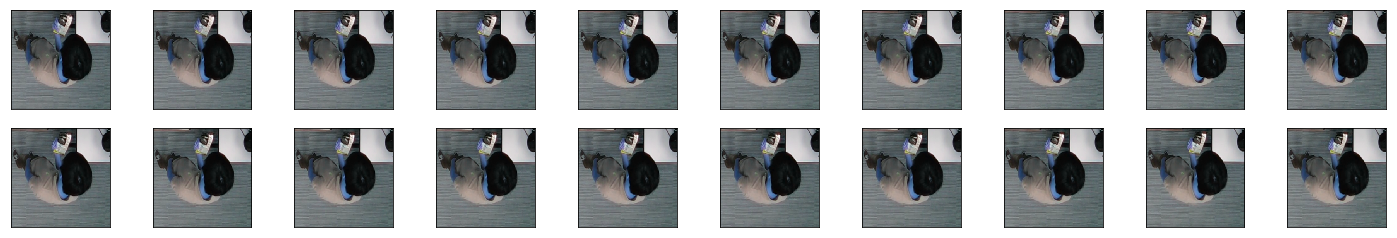

In [24]:
x = 800
images1 = cropped_frames_tensor[x:x+20].cpu().numpy() 
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images1[idx])

In [67]:
dataiter = iter(data_loader)

In [68]:
#for i in range(80):
images1, images2 = dataiter.next()


In [59]:
del images1, images2

In [69]:
len(images2)

512

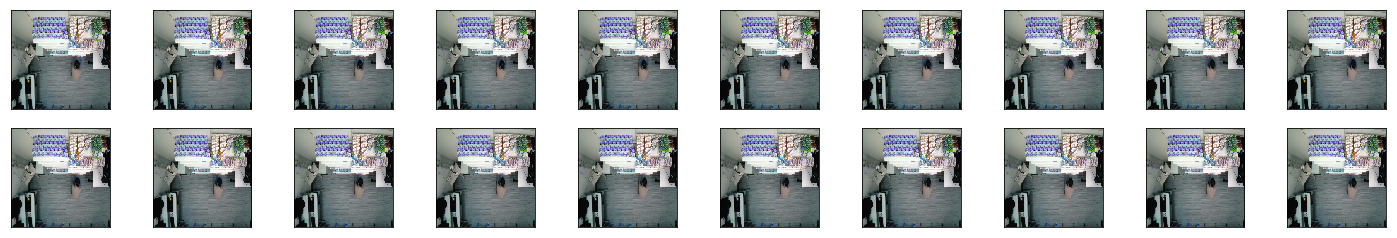

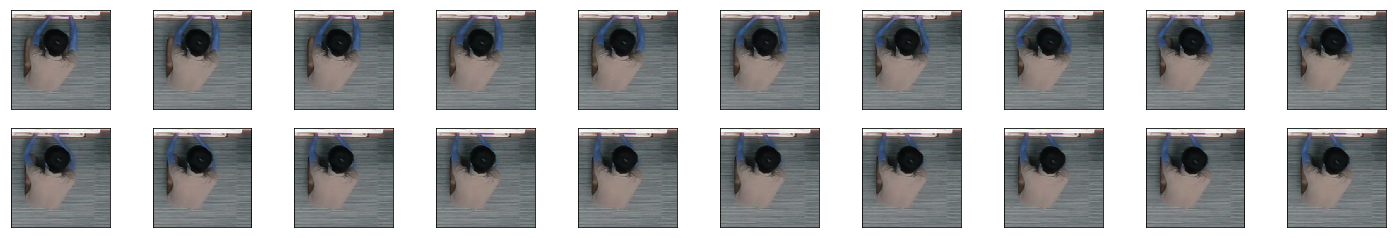

In [44]:
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images1[idx].cpu())
    
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images2[idx].cpu())

In [69]:
len(f_data_loader200.dataset)

1931

In [46]:
len(f_data_loader200)*rnn_batch_size+sequence_length

2131

In [47]:
len(cnn_out200)

2031

In [64]:
for fdata in f_data_loader200:
    print(type(fdata[1]))

IndexError: list index out of range

In [154]:
cnn_out6 = F.log_softmax(cnn_out6, dim=1)
final_out2 =  final_out + cnn_out6.double()
_, pred2 = torch.max(final_out2, 1)

In [156]:
_, pred3 = torch.max(cnn_out6, 1)

In [74]:
for p in pred:
    print(p.item(),end = ',')

0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,5,5,5,0,5,5,5,5,0,0,0,0,0,0,0,0,0,0,0,0,0,5,5,5,5,5,5,5,5,5,1,1,1,3,3,3,3,3,3,3,3,3,3,1,1,1,1,1,3,3,3,3,1,1,2,1,1,1,1,2,2,2,2,2,2,2,2,4,2,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,1,2,4,2,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,1,2,2,2,2,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,2,2,5,5,5,5,5,5,5,5,5,5,5,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,5,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,5,5,5,5,5,5,1,1,1,1,1,1,1,1,1,3,3,3,3,3,3,3,3,3,2,2,2,2,2,2,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,4,4,4,4,4,4,4,4,2,2,2,2,2,2,2,4,2,2,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,2,4,4,4,4,4,4,4,4,4,2,4,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,3,1,1,1,1,1,1,1,1,2,5,5,5,5,5,5,5,5,

In [78]:
idx_to_action = {0:'None',
                 1:'Reach To Shelf',
                 2:'Retract From Shelf',
                 3:'Hand In Shelf',
                 4:'Inspect Product',
                 5:'Inspect Shelf' }

In [143]:

out = cv2.VideoWriter('/home/eng_mostafa_shahin_19/Final_Application/out11.mp4',cv2.VideoWriter_fourcc('M','J','P','G'), 20, (920,680))

video = '/home/eng_mohammed_saad_18/dataset/test/27_1_crop.mp4'
cap = cv2.VideoCapture(video)
n   = 0
idx = 0
while(True):
    idx+=1
    ret, frame = cap.read()
    if not ret:
        break
    if idx%2==0:
        frame = cv2.resize(frame, (920, 680))
        cv2.putText(frame, idx_to_action[pred[n].item()], (20, 320), cv2.FONT_HERSHEY_SIMPLEX, 
                                    2.0, (0, 0, 255), 3 ,lineType=cv2.LINE_AA)
        cv2.putText(frame, idx_to_action[frames2labels[idx]], (320, 320), cv2.FONT_HERSHEY_SIMPLEX, 
                                    2.0, (0, 255, 0), 3 ,lineType=cv2.LINE_AA)            

        out.write(frame)
        n+=1
        print(n)
out.release()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031


In [115]:
video_file_list = os.listdir(test_dir)
video_file_list = sorted(video_file_list,key= ret2)
video_file_list = sorted(video_file_list,key= ret)

In [116]:
video_file_list = os.listdir(test_dir)
label_file_list = os.listdir(testlabel_dir)
video_file_list = sorted(video_file_list,key= ret2)
video_file_list = sorted(video_file_list,key= ret)

videos2labels1={}
for video in video_file_list:
    for labels in label_file_list:
        if video[:-9] == labels[:-10]:
            videos2labels1[video] = labels
            break
video_file_list[:1]

['27_1_crop.mp4']

In [121]:
import scipy.io

targets=[]
videos2labels1={}
for video in video_file_list:
    for labels in label_file_list:
        if video[:-9] == labels[:-10]:
            videos2labels1[video] = labels
            break
for video in video_file_list[:1]:
    cap = cv2.VideoCapture(test_dir+'/'+video)
    count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    n   = 0
    idx = 0
    
    labels_file = videos2labels1[video]
    mat = scipy.io.loadmat(testlabel_dir+'/'+labels_file)
    labels = mat['tlabs']
    frames2labels  = {}

    for f in range(1,count+1):
        frames2labels[f] = 0

    for i,action in enumerate(labels):
        for n in range(len(labels[i][0])):
            start = labels[i][0][n][0]
            end = labels[i][0][n][1]
            for key in range(start,end+1):
                frames2labels[key] = i+1
                
                
    while(True):
        idx+=1
        ret, frame = cap.read()
        if not ret:
            break
        if idx%2==0:
            n+=1
            targets.append(frames2labels[n])
            
            


In [134]:
video_file_list[:1]

['27_1_crop.mp4']

In [135]:
labels_file

'27_1_label.mat'

In [142]:
n=0
for i in range (1,4063,2):
    print(i, frames2labels[i],pred[n].item(),n)
    n+=1

1 0 0 0
3 0 0 1
5 0 0 2
7 0 0 3
9 0 0 4
11 0 0 5
13 0 0 6
15 0 0 7
17 0 0 8
19 0 0 9
21 0 0 10
23 0 0 11
25 0 0 12
27 0 0 13
29 0 0 14
31 0 0 15
33 0 0 16
35 0 0 17
37 0 0 18
39 0 0 19
41 0 0 20
43 0 0 21
45 0 0 22
47 0 0 23
49 0 0 24
51 0 0 25
53 0 0 26
55 0 0 27
57 0 0 28
59 0 0 29
61 0 0 30
63 0 0 31
65 0 0 32
67 0 0 33
69 0 0 34
71 0 0 35
73 0 0 36
75 0 0 37
77 0 0 38
79 0 0 39
81 0 0 40
83 0 0 41
85 0 0 42
87 0 0 43
89 0 0 44
91 0 0 45
93 0 0 46
95 0 0 47
97 0 0 48
99 0 0 49
101 0 0 50
103 0 0 51
105 0 0 52
107 0 0 53
109 0 0 54
111 0 0 55
113 0 0 56
115 0 0 57
117 0 0 58
119 0 0 59
121 0 0 60
123 0 0 61
125 0 0 62
127 0 0 63
129 0 0 64
131 0 0 65
133 0 0 66
135 0 0 67
137 0 0 68
139 0 0 69
141 0 0 70
143 0 0 71
145 0 0 72
147 0 0 73
149 0 0 74
151 0 0 75
153 0 0 76
155 0 0 77
157 0 0 78
159 0 0 79
161 0 0 80
163 0 0 81
165 0 0 82
167 0 0 83
169 0 0 84
171 0 0 85
173 0 0 86
175 0 0 87
177 0 0 88
179 0 5 89
181 0 5 90
183 0 5 91
185 0 5 92
187 0 0 93
189 0 5 94
191 0 5 95
193 0 5 9

1733 0 2 866
1735 0 2 867
1737 0 2 868
1739 0 1 869
1741 0 2 870
1743 0 1 871
1745 0 2 872
1747 0 2 873
1749 0 2 874
1751 0 2 875
1753 0 2 876
1755 0 2 877
1757 0 2 878
1759 0 2 879
1761 0 2 880
1763 0 2 881
1765 0 2 882
1767 0 2 883
1769 0 2 884
1771 0 2 885
1773 0 2 886
1775 0 0 887
1777 0 0 888
1779 0 0 889
1781 0 0 890
1783 0 0 891
1785 0 0 892
1787 0 0 893
1789 0 0 894
1791 0 0 895
1793 0 0 896
1795 0 0 897
1797 0 0 898
1799 0 0 899
1801 0 0 900
1803 0 0 901
1805 0 0 902
1807 0 0 903
1809 0 0 904
1811 0 0 905
1813 0 0 906
1815 0 0 907
1817 0 0 908
1819 0 0 909
1821 0 0 910
1823 0 0 911
1825 0 0 912
1827 0 0 913
1829 0 0 914
1831 0 0 915
1833 0 0 916
1835 0 0 917
1837 0 0 918
1839 0 0 919
1841 0 0 920
1843 0 0 921
1845 0 0 922
1847 0 0 923
1849 0 0 924
1851 0 0 925
1853 0 0 926
1855 0 0 927
1857 0 0 928
1859 0 0 929
1861 0 0 930
1863 0 0 931
1865 0 0 932
1867 0 0 933
1869 0 0 934
1871 0 0 935
1873 0 0 936
1875 0 0 937
1877 0 0 938
1879 0 0 939
1881 0 0 940
1883 0 0 941
1885 0 0 942

3339 4 4 1669
3341 4 4 1670
3343 4 4 1671
3345 4 4 1672
3347 4 4 1673
3349 4 4 1674
3351 4 4 1675
3353 4 4 1676
3355 4 4 1677
3357 4 4 1678
3359 4 4 1679
3361 4 4 1680
3363 4 4 1681
3365 4 4 1682
3367 4 4 1683
3369 4 4 1684
3371 4 4 1685
3373 4 4 1686
3375 4 4 1687
3377 4 4 1688
3379 4 4 1689
3381 4 4 1690
3383 4 4 1691
3385 4 4 1692
3387 4 4 1693
3389 4 4 1694
3391 4 4 1695
3393 4 4 1696
3395 4 4 1697
3397 4 4 1698
3399 4 4 1699
3401 4 4 1700
3403 4 4 1701
3405 4 4 1702
3407 4 4 1703
3409 4 4 1704
3411 4 4 1705
3413 4 4 1706
3415 4 4 1707
3417 4 4 1708
3419 4 4 1709
3421 4 4 1710
3423 4 4 1711
3425 4 4 1712
3427 4 4 1713
3429 4 4 1714
3431 4 4 1715
3433 4 4 1716
3435 4 4 1717
3437 4 4 1718
3439 4 4 1719
3441 4 4 1720
3443 4 4 1721
3445 4 4 1722
3447 4 4 1723
3449 4 4 1724
3451 4 4 1725
3453 4 4 1726
3455 4 4 1727
3457 4 4 1728
3459 4 4 1729
3461 4 4 1730
3463 4 4 1731
3465 4 4 1732
3467 4 4 1733
3469 4 4 1734
3471 4 4 1735
3473 4 4 1736
3475 4 4 1737
3477 4 4 1738
3479 4 4 1739
3481 4

In [153]:
while(1):
    pass

KeyboardInterrupt: 

In [125]:
type(targets[5])

int

In [126]:
targets = torch.FloatTensor(targets)

In [128]:
targets.shape

torch.Size([2031])

In [129]:
pred.shape

torch.Size([2031])

In [133]:
acc=torch.stack(list(pred==targets.long().to(device)))
print('accuracy : ',(torch.sum(acc).item()/len(acc))*100, '%')

accuracy :  40.91580502215657 %


In [155]:
acc=torch.stack(list(pred2==targets.long().to(device)))
print('accuracy : ',(torch.sum(acc).item()/len(acc))*100, '%')

accuracy :  41.16198916789759 %


In [157]:
acc=torch.stack(list(pred3==targets.long().to(device)))
print('accuracy : ',(torch.sum(acc).item()/len(acc))*100, '%')

accuracy :  40.12801575578533 %


In [ ]:
for p,t in zip(pred,targets):
    print(p.item(),'',t.item())